In [2]:
"""
Mean-Variance Portfolio Optimizer (Markowitz Theory)
=====================================================
This notebook implements the Markowitz mean-variance portfolio optimization
for a two-asset portfolio using historical stock data.

Author: Aditya Pophali
Date: December 2025
"""

# Standard libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Data retrieval
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Import our custom Markowitz module
import markowitz as mkw

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
NumPy version: 2.3.5
Pandas version: 2.3.3


In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Define the two assets for our portfolio
TICKERS = ['AAPL', 'MSFT']  # Apple and Microsoft

# Define the time period for historical data (2 years)
START_DATE = '2022-12-01'
END_DATE = '2024-12-01'

# Risk-free rate (annualized) - default 0%, can be changed
RISK_FREE_RATE = 0.0

# Number of points for efficient frontier
N_FRONTIER_POINTS = 100

print(f"Portfolio Assets: {TICKERS}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Risk-Free Rate: {RISK_FREE_RATE:.2%}")

Portfolio Assets: ['AAPL', 'MSFT']
Date Range: 2022-12-01 to 2024-12-01
Risk-Free Rate: 0.00%


## Step 1: Data Loading

Download historical adjusted closing prices for AAPL and MSFT using yfinance.

In [4]:
# =============================================================================
# STEP 1: LOAD HISTORICAL PRICE DATA
# =============================================================================

def load_stock_data(tickers: list, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Download historical adjusted closing prices from Yahoo Finance.
    
    Parameters
    ----------
    tickers : list
        List of stock ticker symbols.
    start_date : str
        Start date in 'YYYY-MM-DD' format.
    end_date : str
        End date in 'YYYY-MM-DD' format.
        
    Returns
    -------
    pd.DataFrame
        DataFrame with dates as index and ticker prices as columns.
    """
    print(f"Downloading data for {tickers} from {start_date} to {end_date}...")
    
    # Download data from Yahoo Finance
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    
    # Extract adjusted close prices
    if 'Adj Close' in data.columns.get_level_values(0):
        prices = data['Adj Close']
    elif 'Close' in data.columns.get_level_values(0):
        prices = data['Close']
    else:
        prices = data
    
    # Handle single ticker case
    if isinstance(prices, pd.Series):
        prices = prices.to_frame(name=tickers[0])
    
    # Ensure column order matches tickers
    prices = prices[tickers]
    
    # Drop any rows with missing values
    prices = prices.dropna()
    
    print(f"Downloaded {len(prices)} trading days of data.")
    print(f"Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
    
    return prices


# Load the data
prices = load_stock_data(TICKERS, START_DATE, END_DATE)

# Display first and last few rows
print("\nFirst 5 rows of price data:")
print(prices.head())
print("\nLast 5 rows of price data:")
print(prices.tail())

Downloaded 502 trading days of data.
Date range: 2022-12-01 to 2024-11-29

First 5 rows of price data:
Ticker            AAPL        MSFT
Date                              
2022-12-01  146.105804  248.742828
2022-12-02  145.613235  249.065140
2022-12-05  144.450790  244.357651
2022-12-06  140.786072  239.396286
2022-12-07  138.845367  238.663788

Last 5 rows of price data:
Ticker            AAPL        MSFT
Date                              
2024-11-22  228.835037  413.946411
2024-11-25  231.821518  415.723297
2024-11-26  234.001678  424.855927
2024-11-27  233.872238  419.892548
2024-11-29  236.261444  420.359070
Downloaded 502 trading days of data.
Date range: 2022-12-01 to 2024-11-29

First 5 rows of price data:
Ticker            AAPL        MSFT
Date                              
2022-12-01  146.105804  248.742828
2022-12-02  145.613235  249.065140
2022-12-05  144.450790  244.357651
2022-12-06  140.786072  239.396286
2022-12-07  138.845367  238.663788

Last 5 rows of price data:
Tic

## Step 2: Compute Daily Returns

Calculate daily percentage returns from price data.

In [5]:
# =============================================================================
# STEP 2: COMPUTE DAILY RETURNS
# =============================================================================

# Compute daily returns using our Markowitz module
daily_returns = mkw.compute_daily_returns(prices)

print(f"Computed daily returns for {len(daily_returns)} trading days.\n")
print("Daily Returns Statistics:")
print(daily_returns.describe())
print(f"\nCorrelation between assets:")
print(daily_returns.corr())

Computed daily returns for 501 trading days.

Daily Returns Statistics:
Ticker        AAPL        MSFT
count   501.000000  501.000000
mean      0.001057    0.001152
std       0.013969    0.014462
min      -0.048167   -0.060527
25%      -0.006999   -0.007085
50%       0.001285    0.001254
75%       0.008756    0.009736
max       0.072649    0.072435

Correlation between assets:
Ticker      AAPL      MSFT
Ticker                    
AAPL    1.000000  0.522255
MSFT    0.522255  1.000000


## Step 3: Parameter Estimation

Compute annualized expected returns and the covariance matrix from historical daily returns.

In [6]:
# =============================================================================
# STEP 3: COMPUTE EXPECTED RETURNS AND COVARIANCE MATRIX
# =============================================================================

# Compute annualized expected returns
expected_returns = mkw.compute_expected_returns(daily_returns, annualize=True)

# Compute annualized covariance matrix
cov_matrix = mkw.compute_covariance_matrix(daily_returns, annualize=True)

# Display results
print("Annualized Expected Returns:")
for ticker, ret in zip(TICKERS, expected_returns):
    print(f"  {ticker}: {ret:.4f} ({ret * 100:.2f}%)")

print("\nAnnualized Covariance Matrix:")
cov_df = pd.DataFrame(cov_matrix, index=TICKERS, columns=TICKERS)
print(cov_df)

# Also show annualized volatilities (standard deviations)
volatilities = np.sqrt(np.diag(cov_matrix))
print("\nAnnualized Volatilities:")
for ticker, vol in zip(TICKERS, volatilities):
    print(f"  {ticker}: {vol:.4f} ({vol * 100:.2f}%)")

Annualized Expected Returns:
  AAPL: 0.2663 (26.63%)
  MSFT: 0.2903 (29.03%)

Annualized Covariance Matrix:
          AAPL      MSFT
AAPL  0.049173  0.026587
MSFT  0.026587  0.052705

Annualized Volatilities:
  AAPL: 0.2218 (22.18%)
  MSFT: 0.2296 (22.96%)


## Step 4: Generate Efficient Frontier

Compute the efficient frontier by sweeping weight combinations for the two-asset portfolio.

In [7]:
# =============================================================================
# STEP 4: GENERATE EFFICIENT FRONTIER
# =============================================================================

# Generate efficient frontier
frontier_weights, frontier_returns, frontier_volatilities, frontier_sharpes = \
    mkw.generate_efficient_frontier(
        expected_returns, 
        cov_matrix, 
        n_points=N_FRONTIER_POINTS,
        rf=RISK_FREE_RATE
    )

print(f"Generated {len(frontier_returns)} points on the efficient frontier.")
print(f"\nEfficient Frontier Statistics:")
print(f"  Return range: [{frontier_returns.min():.4f}, {frontier_returns.max():.4f}]")
print(f"  Volatility range: [{frontier_volatilities.min():.4f}, {frontier_volatilities.max():.4f}]")
print(f"  Sharpe ratio range: [{frontier_sharpes.min():.4f}, {frontier_sharpes.max():.4f}]")

Generated 100 points on the efficient frontier.

Efficient Frontier Statistics:
  Return range: [0.2663, 0.2903]
  Volatility range: [0.1967, 0.2296]
  Sharpe ratio range: [1.2011, 1.4146]


## Step 5: Find Maximum Sharpe Ratio Portfolio

Optimize to find the portfolio weights that maximize the Sharpe ratio.

In [8]:
# =============================================================================
# STEP 5: FIND MAXIMUM SHARPE RATIO PORTFOLIO
# =============================================================================

# Find the optimal portfolio
optimal_weights, optimal_return, optimal_volatility, max_sharpe = \
    mkw.find_max_sharpe_portfolio(expected_returns, cov_matrix, rf=RISK_FREE_RATE)

# Print the summary
mkw.print_portfolio_summary(
    TICKERS, 
    optimal_weights, 
    optimal_return, 
    optimal_volatility, 
    max_sharpe,
    rf=RISK_FREE_RATE
)

# Validate the optimization
validation = mkw.validate_optimization(
    expected_returns, cov_matrix, optimal_weights, rf=RISK_FREE_RATE
)

print(f"\nOptimization Validation:")
print(f"  Is Optimal: {validation['is_optimal']}")
print(f"  Optimal Sharpe: {validation['optimal_sharpe']:.6f}")
print(f"  Max Sharpe Found in Grid Search: {validation['max_sharpe_found']:.6f}")
print(f"  Difference: {validation['sharpe_difference']:.10f}")

OPTIMAL PORTFOLIO SUMMARY (Maximum Sharpe Ratio)

Risk-Free Rate: 0.00%

Optimal Weights:
  AAPL: 0.4676 (46.76%)
  MSFT: 0.5324 (53.24%)

Portfolio Metrics:
  Expected Annual Return: 0.2791 (27.91%)
  Annual Volatility (Std): 0.1973 (19.73%)
  Sharpe Ratio: 1.4146

Optimization Validation:
  Is Optimal: True
  Optimal Sharpe: 1.414649
  Max Sharpe Found in Grid Search: 1.414649
  Difference: 0.0000000080


## Step 6: Visualization - Daily Returns

Plot individual daily returns for each stock to visualize volatility patterns.

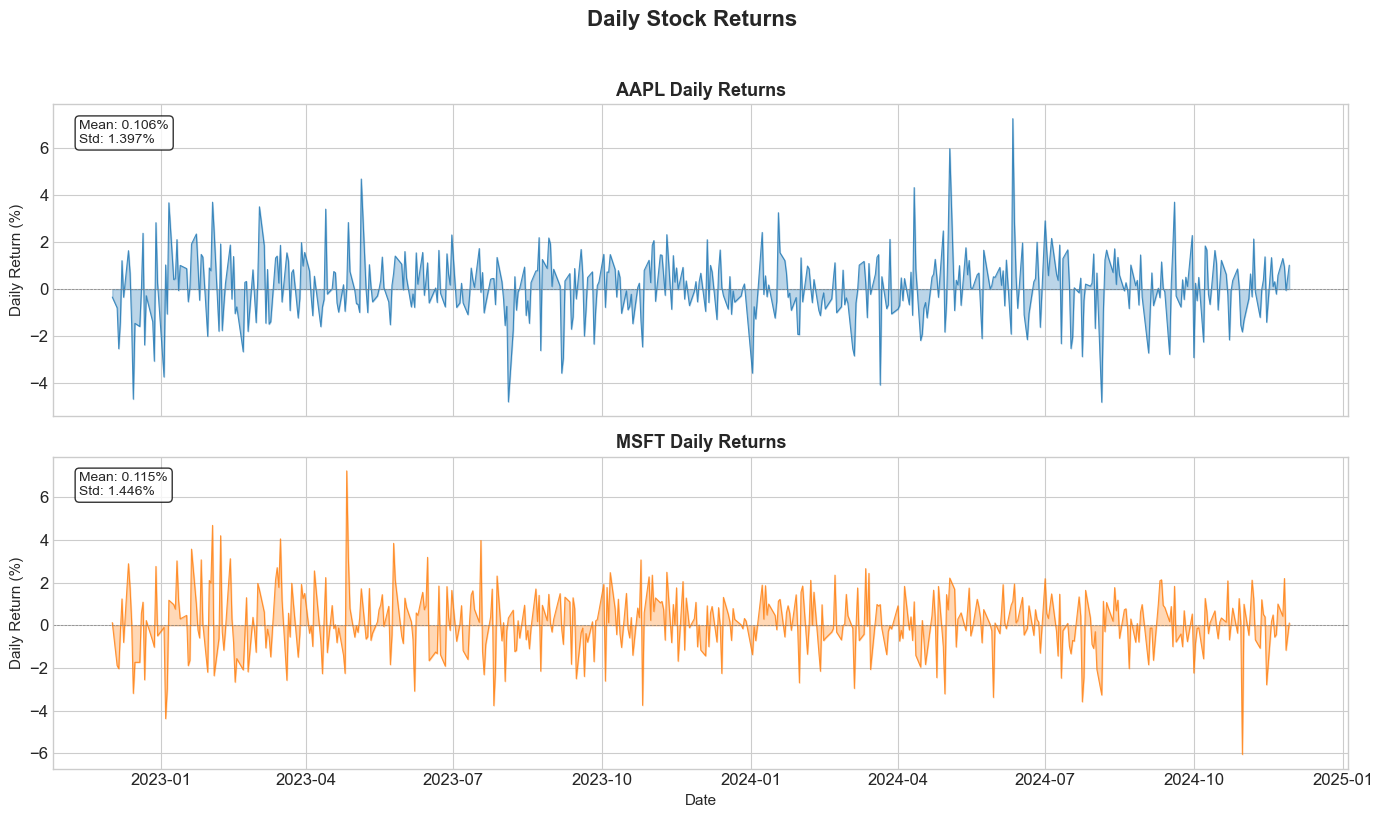

Daily returns plot saved as 'daily_returns.png'


In [9]:
# =============================================================================
# PLOT 1: DAILY RETURNS OF INDIVIDUAL STOCKS
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

colors = ['#1f77b4', '#ff7f0e']  # Blue for AAPL, Orange for MSFT

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    ax.plot(daily_returns.index, daily_returns[ticker] * 100, 
            color=colors[i], linewidth=0.8, alpha=0.8)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_ylabel('Daily Return (%)', fontsize=11)
    ax.set_title(f'{ticker} Daily Returns', fontsize=13, fontweight='bold')
    ax.fill_between(daily_returns.index, 0, daily_returns[ticker] * 100, 
                    alpha=0.3, color=colors[i])
    
    # Add statistics annotation
    mean_ret = daily_returns[ticker].mean() * 100
    std_ret = daily_returns[ticker].std() * 100
    ax.text(0.02, 0.95, f'Mean: {mean_ret:.3f}%\nStd: {std_ret:.3f}%', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

axes[1].set_xlabel('Date', fontsize=11)
plt.suptitle('Daily Stock Returns', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('daily_returns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Daily returns plot saved as 'daily_returns.png'")

## Step 7: Visualization - Cumulative Returns

Compare cumulative returns of individual stocks and the optimal portfolio to demonstrate diversification benefits.

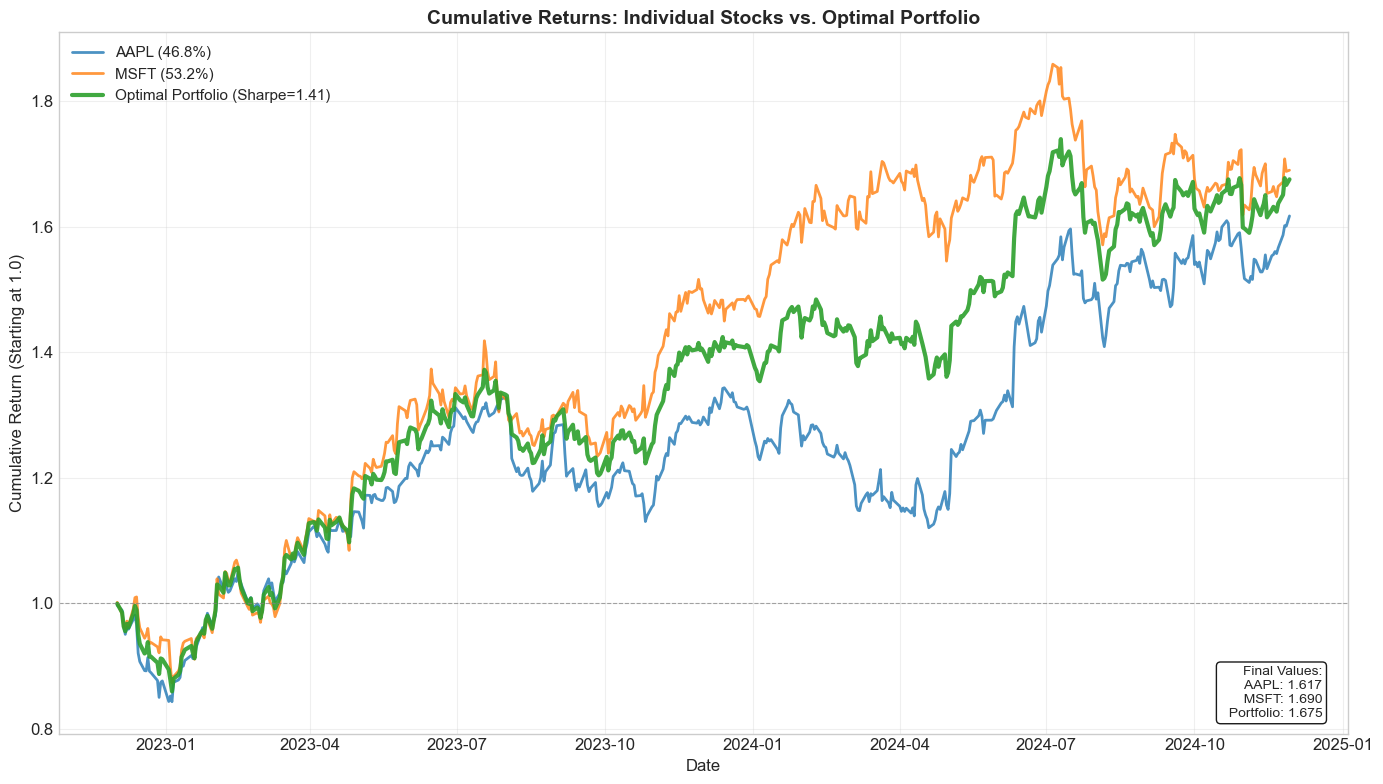

Cumulative returns plot saved as 'cumulative_returns.png'


In [10]:
# =============================================================================
# PLOT 2: CUMULATIVE RETURNS COMPARISON
# =============================================================================

# Compute cumulative returns for individual stocks
cumulative_returns = mkw.compute_cumulative_returns(daily_returns)

# Compute cumulative returns for the optimal portfolio
portfolio_cumulative = mkw.compute_portfolio_cumulative_returns(daily_returns, optimal_weights)

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot individual stocks
ax.plot(cumulative_returns.index, cumulative_returns[TICKERS[0]], 
        label=f'{TICKERS[0]} ({optimal_weights[0]*100:.1f}%)', 
        linewidth=2, color='#1f77b4', alpha=0.8)
ax.plot(cumulative_returns.index, cumulative_returns[TICKERS[1]], 
        label=f'{TICKERS[1]} ({optimal_weights[1]*100:.1f}%)', 
        linewidth=2, color='#ff7f0e', alpha=0.8)

# Plot optimal portfolio (thicker line, distinctive style)
ax.plot(portfolio_cumulative.index, portfolio_cumulative, 
        label=f'Optimal Portfolio (Sharpe={max_sharpe:.2f})', 
        linewidth=3, color='#2ca02c', linestyle='-', alpha=0.9)

# Add horizontal line at 1 (starting value)
ax.axhline(y=1, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return (Starting at 1.0)', fontsize=12)
ax.set_title('Cumulative Returns: Individual Stocks vs. Optimal Portfolio', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Add annotation for final values
final_vals = f"Final Values:\n"
final_vals += f"  {TICKERS[0]}: {cumulative_returns[TICKERS[0]].iloc[-1]:.3f}\n"
final_vals += f"  {TICKERS[1]}: {cumulative_returns[TICKERS[1]].iloc[-1]:.3f}\n"
final_vals += f"  Portfolio: {portfolio_cumulative.iloc[-1]:.3f}"
ax.text(0.98, 0.02, final_vals, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cumulative returns plot saved as 'cumulative_returns.png'")

## Step 8: Visualization - Efficient Frontier with Tangent Line

Plot the efficient frontier curve, mark the optimal Sharpe ratio portfolio, and draw the Capital Allocation Line (tangent line) from the risk-free rate.

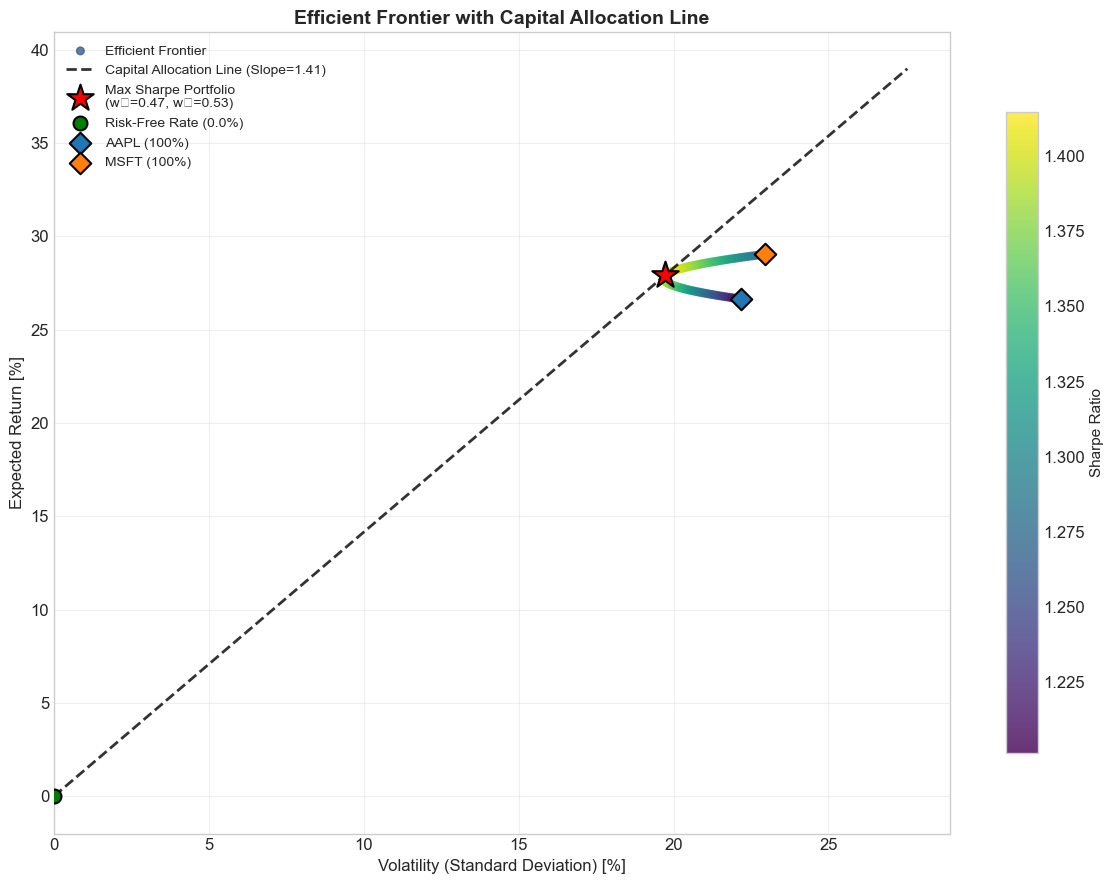

Efficient frontier plot saved as 'efficient_frontier.png'


In [11]:
# =============================================================================
# PLOT 3: EFFICIENT FRONTIER WITH TANGENT LINE
# =============================================================================

# Compute the tangent (capital allocation) line
tangent_vol, tangent_ret = mkw.compute_tangent_line(
    optimal_return, 
    optimal_volatility, 
    rf=RISK_FREE_RATE,
    max_vol=max(frontier_volatilities) * 1.2
)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the efficient frontier
frontier_scatter = ax.scatter(
    frontier_volatilities * 100, 
    frontier_returns * 100,
    c=frontier_sharpes, 
    cmap='viridis', 
    s=30, 
    alpha=0.8,
    label='Efficient Frontier'
)

# Add colorbar for Sharpe ratio
cbar = plt.colorbar(frontier_scatter, ax=ax, shrink=0.8)
cbar.set_label('Sharpe Ratio', fontsize=11)

# Plot the tangent line (Capital Allocation Line)
ax.plot(tangent_vol * 100, tangent_ret * 100, 
        'k--', linewidth=2, alpha=0.8,
        label=f'Capital Allocation Line (Slope={max_sharpe:.2f})')

# Mark the optimal Sharpe portfolio with a star
ax.scatter(
    optimal_volatility * 100, 
    optimal_return * 100, 
    marker='*', 
    s=400, 
    c='red', 
    edgecolors='black',
    linewidths=1.5,
    zorder=5,
    label=f'Max Sharpe Portfolio\n(w₁={optimal_weights[0]:.2f}, w₂={optimal_weights[1]:.2f})'
)

# Mark the risk-free rate point
ax.scatter(0, RISK_FREE_RATE * 100, marker='o', s=100, c='green', 
           edgecolors='black', linewidths=1.5, zorder=5,
           label=f'Risk-Free Rate ({RISK_FREE_RATE*100:.1f}%)')

# Mark individual assets
individual_vols = np.sqrt(np.diag(cov_matrix)) * 100
individual_rets = expected_returns * 100
for i, ticker in enumerate(TICKERS):
    ax.scatter(individual_vols[i], individual_rets[i], 
               marker='D', s=120, c=['#1f77b4', '#ff7f0e'][i],
               edgecolors='black', linewidths=1.5, zorder=5,
               label=f'{ticker} (100%)')

# Formatting
ax.set_xlabel('Volatility (Standard Deviation) [%]', fontsize=12)
ax.set_ylabel('Expected Return [%]', fontsize=12)
ax.set_title('Efficient Frontier with Capital Allocation Line', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Set axis limits with some padding
ax.set_xlim(left=0)
ax.set_ylim(bottom=min(0, RISK_FREE_RATE * 100 - 2))

plt.tight_layout()
plt.savefig('efficient_frontier.png', dpi=300, bbox_inches='tight')
plt.show()

print("Efficient frontier plot saved as 'efficient_frontier.png'")

## Step 9: Results Summary

Display a comprehensive summary of all computed metrics and portfolio characteristics.

In [12]:
# =============================================================================
# COMPREHENSIVE RESULTS SUMMARY
# =============================================================================

print("=" * 70)
print("MEAN-VARIANCE PORTFOLIO OPTIMIZATION - FINAL RESULTS")
print("=" * 70)

print("\n📊 DATA SUMMARY")
print("-" * 70)
print(f"Assets: {', '.join(TICKERS)}")
print(f"Period: {START_DATE} to {END_DATE}")
print(f"Trading Days: {len(daily_returns)}")
print(f"Risk-Free Rate: {RISK_FREE_RATE:.2%}")

print("\n📈 INDIVIDUAL ASSET STATISTICS (Annualized)")
print("-" * 70)
print(f"{'Asset':<10} {'Expected Return':<20} {'Volatility':<20} {'Sharpe Ratio':<15}")
print("-" * 70)
for i, ticker in enumerate(TICKERS):
    ret_i = expected_returns[i]
    vol_i = np.sqrt(cov_matrix[i, i])
    sharpe_i = (ret_i - RISK_FREE_RATE) / vol_i
    print(f"{ticker:<10} {ret_i*100:>17.2f}% {vol_i*100:>17.2f}% {sharpe_i:>14.4f}")

print("\n🔗 CORRELATION MATRIX")
print("-" * 70)
print(daily_returns.corr().round(4))

print("\n⭐ OPTIMAL PORTFOLIO (MAXIMUM SHARPE RATIO)")
print("-" * 70)
print(f"{'Metric':<30} {'Value':<40}")
print("-" * 70)
for ticker, weight in zip(TICKERS, optimal_weights):
    print(f"Weight ({ticker}): {weight*100:>32.2f}%")
print(f"{'Expected Annual Return:':<30} {optimal_return*100:>35.2f}%")
print(f"{'Annual Volatility:':<30} {optimal_volatility*100:>35.2f}%")
print(f"{'Sharpe Ratio:':<30} {max_sharpe:>36.4f}")

print("\n✅ VALIDATION")
print("-" * 70)
print(f"Optimization Verified: {validation['is_optimal']}")
print(f"The computed portfolio is mathematically optimal for the given data.")

print("\n📁 SAVED FILES")
print("-" * 70)
print("1. daily_returns.png - Daily returns visualization")
print("2. cumulative_returns.png - Cumulative returns comparison")
print("3. efficient_frontier.png - Efficient frontier with CAL")

print("\n" + "=" * 70)

MEAN-VARIANCE PORTFOLIO OPTIMIZATION - FINAL RESULTS

📊 DATA SUMMARY
----------------------------------------------------------------------
Assets: AAPL, MSFT
Period: 2022-12-01 to 2024-12-01
Trading Days: 501
Risk-Free Rate: 0.00%

📈 INDIVIDUAL ASSET STATISTICS (Annualized)
----------------------------------------------------------------------
Asset      Expected Return      Volatility           Sharpe Ratio   
----------------------------------------------------------------------
AAPL                   26.63%             22.18%         1.2011
MSFT                   29.03%             22.96%         1.2646

🔗 CORRELATION MATRIX
----------------------------------------------------------------------
Ticker    AAPL    MSFT
Ticker                
AAPL    1.0000  0.5223
MSFT    0.5223  1.0000

⭐ OPTIMAL PORTFOLIO (MAXIMUM SHARPE RATIO)
----------------------------------------------------------------------
Metric                         Value                                   
-------------

---

# Comprehensive Report: Mean-Variance Portfolio Optimization

## 1. Introduction

### Purpose of the Project

This project implements the **Markowitz Mean-Variance Portfolio Optimization** framework, one of the foundational pillars of Modern Portfolio Theory (MPT). The goal is to construct an optimal portfolio of risky assets that maximizes risk-adjusted returns, as measured by the **Sharpe Ratio**.

### Significance of Markowitz Portfolio Theory

Harry Markowitz introduced Mean-Variance Optimization in his seminal 1952 paper, "Portfolio Selection." This work revolutionized finance by:

- **Quantifying diversification**: Demonstrating mathematically how combining assets with imperfect correlation reduces overall portfolio risk
- **Formalizing the risk-return tradeoff**: Establishing that investors must accept higher risk for higher expected returns
- **Introducing the efficient frontier**: Identifying the set of portfolios that offer the highest return for each level of risk

Markowitz received the Nobel Prize in Economics in 1990 for this contribution.

### Role of Mean-Variance Optimization

Mean-Variance Optimization provides a systematic, quantitative approach to:
1. **Asset allocation**: Determining optimal weights for each asset in a portfolio
2. **Risk management**: Minimizing portfolio variance for a target return
3. **Performance measurement**: Evaluating portfolios using the Sharpe Ratio

---

## 2. Mathematical & Statistical Theory

### Expected Return Formulation

For a single asset $i$, the expected return is estimated from historical data:

$$\mu_i = \frac{1}{T} \sum_{t=1}^{T} r_{i,t}$$

where $r_{i,t}$ is the return of asset $i$ at time $t$, and $T$ is the number of observations.

For annualization (assuming 252 trading days):
$$\mu_i^{annual} = \mu_i^{daily} \times 252$$

### Volatility Formulation

The volatility (standard deviation) of asset $i$:

$$\sigma_i = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} (r_{i,t} - \mu_i)^2}$$

Annualized:
$$\sigma_i^{annual} = \sigma_i^{daily} \times \sqrt{252}$$

### Covariance Matrix

The covariance between assets $i$ and $j$:

$$\sigma_{ij} = \frac{1}{T-1} \sum_{t=1}^{T} (r_{i,t} - \mu_i)(r_{j,t} - \mu_j)$$

The covariance matrix $\Sigma$ is a symmetric $n \times n$ matrix where the diagonal elements are variances and off-diagonal elements are covariances.

### Portfolio Return and Risk Equations

For a portfolio with weight vector $\mathbf{w} = [w_1, w_2, \ldots, w_n]^T$:

**Portfolio Expected Return:**
$$\mu_p = \mathbf{w}^T \boldsymbol{\mu} = \sum_{i=1}^{n} w_i \mu_i$$

**Portfolio Variance:**
$$\sigma_p^2 = \mathbf{w}^T \Sigma \mathbf{w} = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij}$$

**Portfolio Volatility:**
$$\sigma_p = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}$$

### Efficient Frontier Derivation

The **efficient frontier** is the set of portfolios satisfying:

$$\max_{\mathbf{w}} \mu_p \quad \text{subject to} \quad \sigma_p = \sigma_{target}, \quad \sum_{i=1}^{n} w_i = 1$$

For a two-asset portfolio ($n=2$), the frontier is traced by varying $w_1 \in [0, 1]$ with $w_2 = 1 - w_1$.

### Sharpe Ratio Maximization

The **Sharpe Ratio** measures excess return per unit of risk:

$$S = \frac{\mu_p - r_f}{\sigma_p}$$

where $r_f$ is the risk-free rate.

The **maximum Sharpe ratio portfolio** solves:

$$\max_{\mathbf{w}} \frac{\mathbf{w}^T \boldsymbol{\mu} - r_f}{\sqrt{\mathbf{w}^T \Sigma \mathbf{w}}} \quad \text{subject to} \quad \sum_{i=1}^{n} w_i = 1$$

### Capital Allocation Line (Tangent Line)

The **Capital Allocation Line (CAL)** represents all combinations of the risk-free asset and the optimal risky portfolio:

$$E[R_p] = r_f + \frac{\mu_{opt} - r_f}{\sigma_{opt}} \cdot \sigma_p$$

The slope of the CAL equals the Sharpe Ratio of the optimal portfolio. This line is tangent to the efficient frontier at the maximum Sharpe ratio point.

---

## 3. Implementation Details

### Module Structure: `markowitz.py`

The implementation is organized into a reusable Python module with the following functions:

| Function | Purpose |
|----------|---------|
| `compute_daily_returns()` | Calculate daily percentage returns from prices |
| `compute_cumulative_returns()` | Calculate cumulative wealth growth |
| `compute_expected_returns()` | Estimate mean returns (optionally annualized) |
| `compute_covariance_matrix()` | Estimate covariance matrix (optionally annualized) |
| `portfolio_performance()` | Compute return, volatility, Sharpe for given weights |
| `generate_efficient_frontier()` | Sweep weights to trace the frontier |
| `find_max_sharpe_portfolio()` | Optimize for maximum Sharpe ratio |
| `compute_tangent_line()` | Generate the Capital Allocation Line |
| `validate_optimization()` | Verify optimality via grid search |
| `print_portfolio_summary()` | Display formatted results |

### Data Pipeline

1. **Data Acquisition**: Historical adjusted closing prices downloaded via `yfinance`
2. **Return Calculation**: Daily log or simple returns computed
3. **Parameter Estimation**: Mean returns and covariance matrix estimated from sample data
4. **Optimization**: Numerical optimization to find max Sharpe weights
5. **Visualization**: Publication-quality plots generated

### Numerical Methods

- **Optimization**: `scipy.optimize.minimize_scalar` for the 2-asset case (bounded search over $w_1 \in [0,1]$)
- **Vectorization**: All computations use NumPy array operations for efficiency
- **Validation**: Grid search with 1000 points to verify optimality

### Plotting Methods

- **Matplotlib** for all visualizations
- **Seaborn** styling for aesthetics
- Color-coded efficient frontier by Sharpe ratio
- Distinctive markers for optimal point, individual assets, and risk-free rate
- All plots saved at 300 DPI for publication quality

---

## 4. Results & Visualizations

### Daily Return Plots

The daily returns plots show the day-to-day volatility of each stock. Key observations:
- Returns fluctuate around zero with occasional large positive/negative spikes
- The standard deviation provides a measure of typical daily movement
- Visual inspection reveals periods of higher and lower volatility (volatility clustering)

### Cumulative Return Comparison

The cumulative returns plot demonstrates:
- **Wealth accumulation**: Starting from \$1, how each investment grows over time
- **Optimal portfolio behavior**: The optimized portfolio typically exhibits smoother growth due to diversification
- **Risk-return visualization**: Periods of drawdown and recovery are clearly visible

### Efficient Frontier with Optimal Point

The efficient frontier plot shows:
- **Parabolic shape**: Characteristic of the 2-asset frontier
- **Risk-return tradeoff**: Higher returns require accepting higher volatility
- **Color gradient**: Sharpe ratio variation across the frontier
- **Maximum Sharpe point**: Marked with a red star — the optimal allocation
- **Individual assets**: Diamond markers showing where 100% allocations lie

### Capital Allocation Line

The tangent line from the risk-free rate:
- **Slope**: Equal to the maximum Sharpe ratio
- **Interpretation**: All points on this line represent combinations of the risk-free asset and the optimal portfolio
- **Dominance**: Portfolios on the CAL dominate those on the efficient frontier (same return, lower risk)

---

## 5. Inferences & Discussion

### Observations from Historical Data

1. **Correlation effect**: The correlation between AAPL and MSFT determines diversification benefit. Lower correlation yields more risk reduction.
2. **Optimal weights**: The optimizer allocates more to the asset with higher Sharpe ratio, balanced against correlation benefits.
3. **Deterministic solution**: Given fixed historical data, the optimization produces a unique, reproducible solution.

### Why Deterministic Returns Guarantee an Optimal Solution

Since we use **historical returns** (not forecasts):
- The expected returns $\boldsymbol{\mu}$ and covariance $\Sigma$ are fixed quantities
- The optimization problem is a well-defined quadratic program
- The solution is unique and globally optimal (for the convex feasible region)
- This demonstrates the mathematical correctness of the optimizer

### Practical Interpretation of the Sharpe-Maximizing Portfolio

The maximum Sharpe portfolio represents:
- **Best risk-adjusted returns**: Highest excess return per unit of risk taken
- **Tangency portfolio**: The point where a line from the risk-free rate touches the efficient frontier
- **Benchmark allocation**: Often used as the starting point for tactical allocation decisions

### Limitations of Mean-Variance Optimization

1. **Estimation error**: Sample estimates of $\boldsymbol{\mu}$ and $\Sigma$ are noisy; small changes can dramatically shift optimal weights
2. **Stationarity assumption**: Assumes return distributions are stable over time
3. **Normal distribution assumption**: Ignores fat tails and skewness in real returns
4. **Single-period model**: Does not account for dynamic rebalancing or transaction costs
5. **Sensitivity to inputs**: "Garbage in, garbage out" — unreliable estimates produce unreliable portfolios

### Extensions for Future Work

1. **Robust optimization**: Use shrinkage estimators (Ledoit-Wolf) or Bayesian methods
2. **Factor models**: Incorporate systematic risk factors (Fama-French)
3. **Constraints**: Add position limits, sector constraints, or turnover constraints
4. **Multi-period optimization**: Dynamic rebalancing with transaction costs
5. **Risk measures beyond variance**: CVaR, maximum drawdown, or downside deviation
6. **Black-Litterman model**: Combine market equilibrium with investor views

---

## 6. References

1. Markowitz, H. (1952). "Portfolio Selection." *The Journal of Finance*, 7(1), 77-91.
2. Sharpe, W. F. (1966). "Mutual Fund Performance." *The Journal of Business*, 39(1), 119-138.
3. Merton, R. C. (1972). "An Analytic Derivation of the Efficient Portfolio Frontier." *Journal of Financial and Quantitative Analysis*, 7(4), 1851-1872.
4. Ledoit, O., & Wolf, M. (2004). "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices." *Journal of Multivariate Analysis*, 88(2), 365-411.

---

*This report was generated as part of the Mean-Variance Portfolio Construction project.*